In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import glob
import scipy.stats
from IPython.display import Video, display, HTML
sns.set()

def read_csvx(path, *args, **kwargs):
    try:
        return pd.read_csv(str(path) +'.gz', *args, **kwargs)
    except Exception as e:
        return pd.read_csv(str(path), *args, **kwargs)

def followorbit(vals, path):
    out = []
    for n in range(100):
        closest05 = np.clip(round(path[n] * 2) / 2, 0, 10)
        rank = vals.query(f'nbopp == {n} and othercoop == {closest05}')['rank'].values[0]
        out.append(rank)
    return np.array(out)

import re
def gethighest(vals, prefix="logall_"):
        m = np.argmax([int(re.search(f'{prefix}(\d+)', val).group(1)) for val in vals])
        return vals[m]

    
def readparams(file):
    params = {} 
    with open(file) as f:
        for line in f:
            line = line[:-1]  # remove \n
            if not line or line.startswith('#') or line.startswith('import'):
                continue
            key, val = line.split('=')
            if val.lower() == 'true' or val.lower() == 'false':
                params[key] = val.lower() == 'true'
            else:
                try:
                    params[key] = float(val)
                except ValueError:
                    params[key] = val
    return params

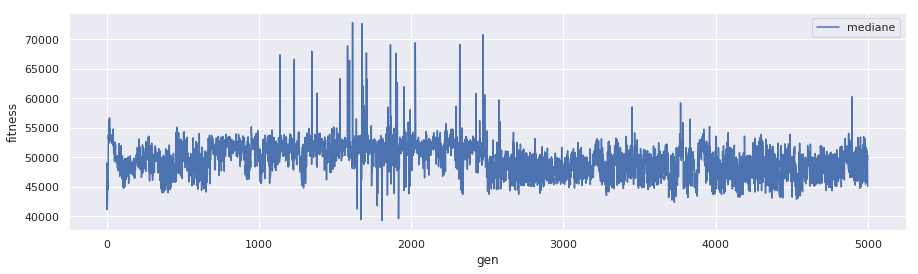

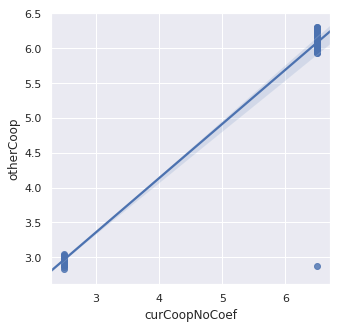

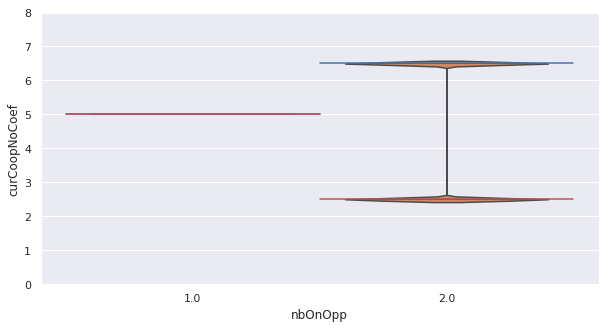

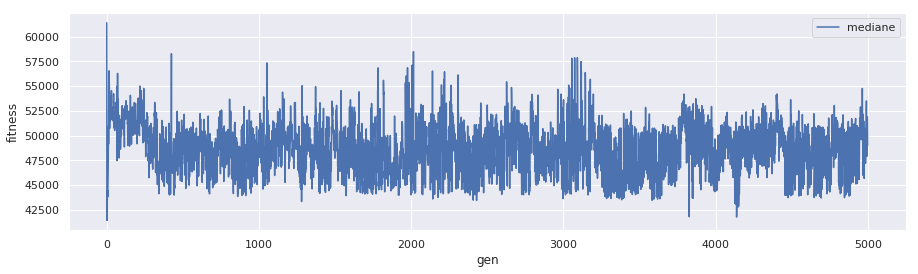

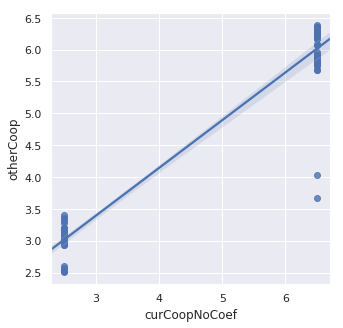

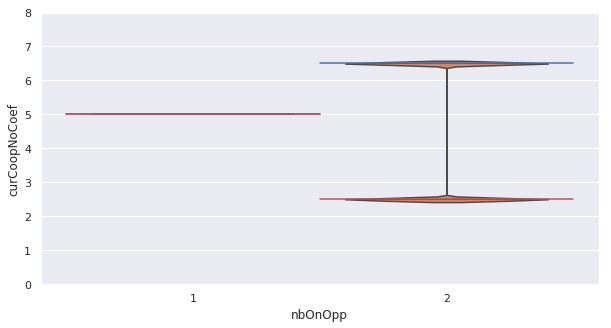

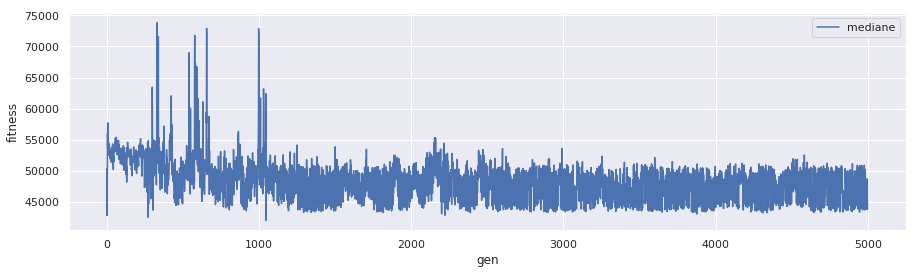

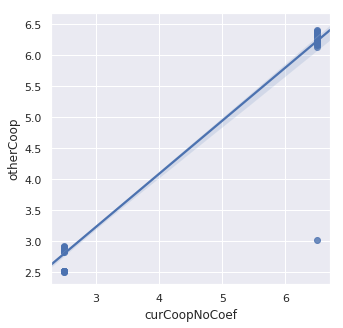

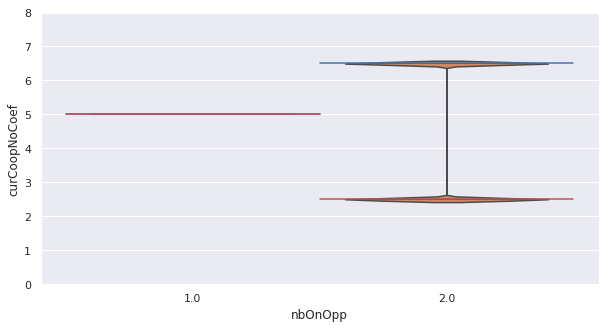

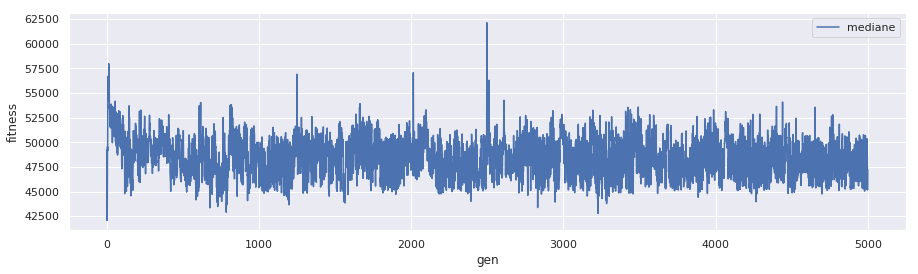

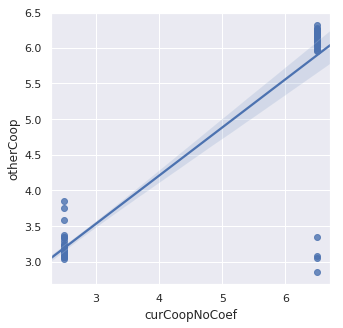

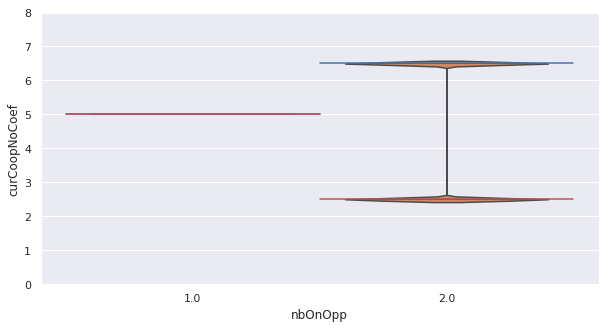

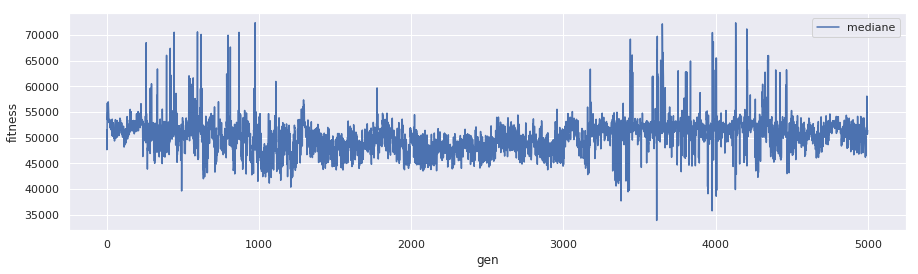

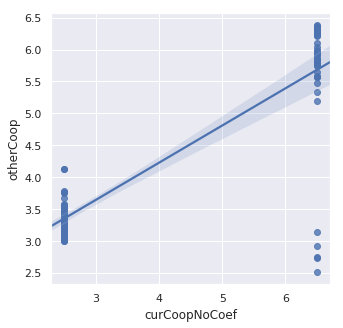

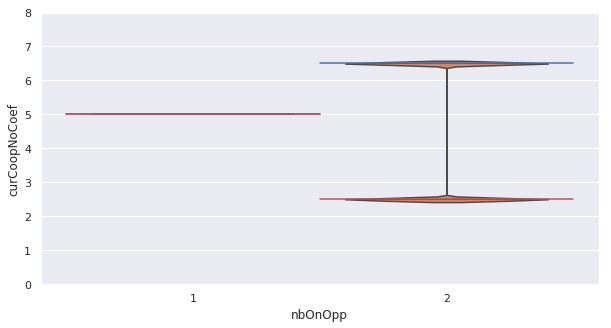

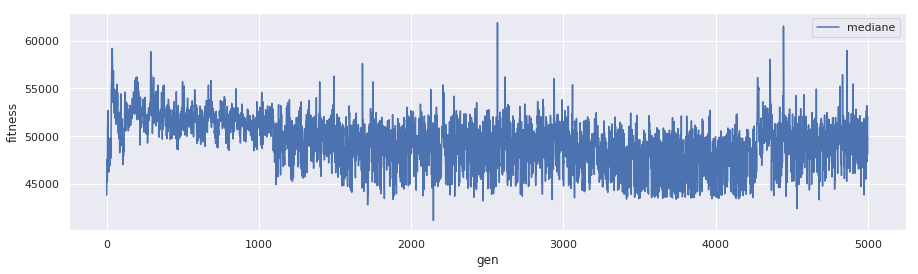

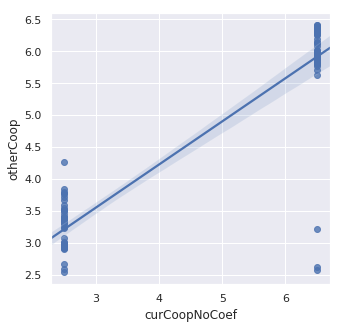

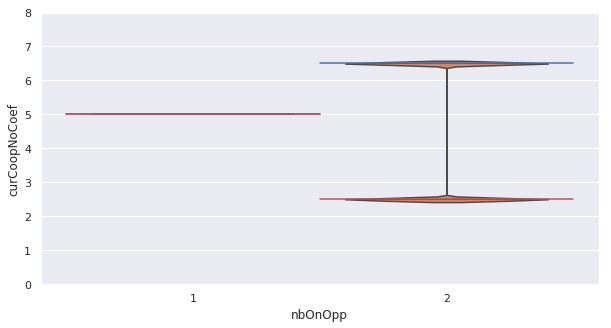

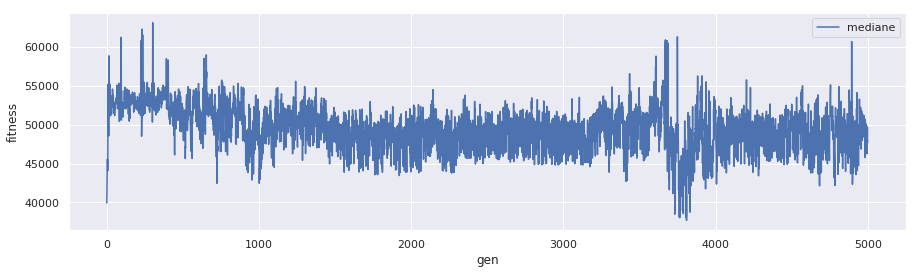

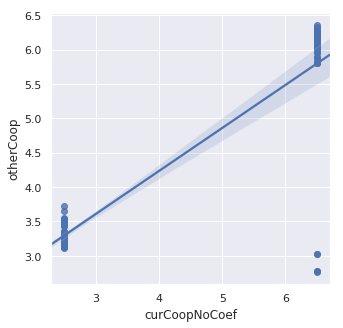

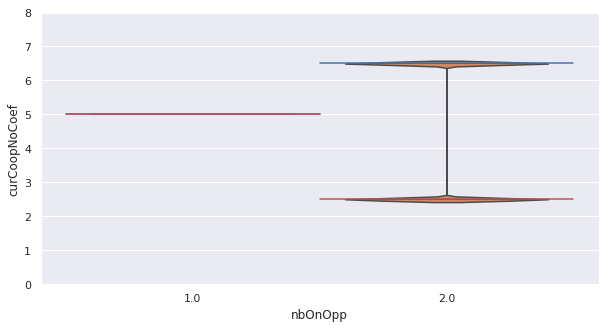

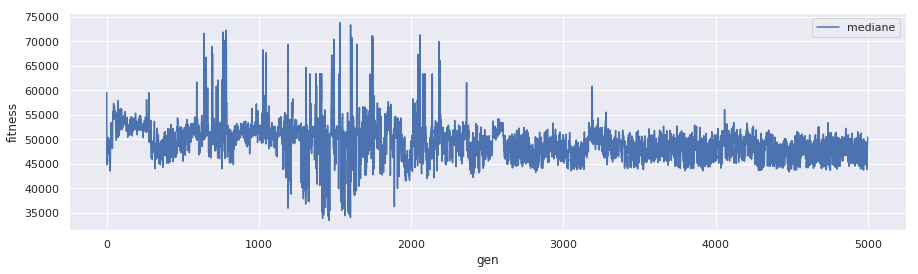

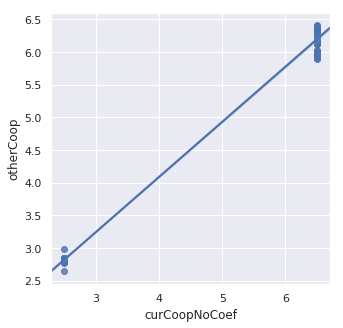

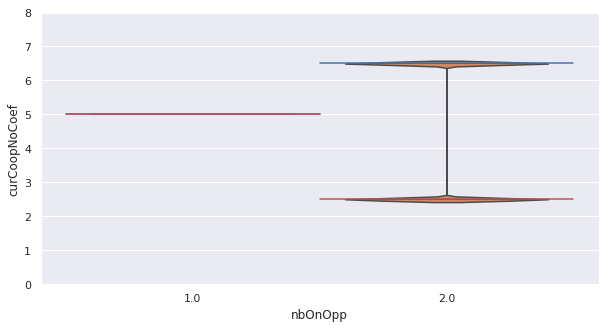

In [10]:
dofolloworbit = True
for path in sorted(glob.glob("/home/pecoffet/remoterobo/logs/lions-maxtwo-pop100-independant-fake_true-b3-nocost-decay-100-2019-06-04-*/**/rep00/", recursive=True)):
    display(HTML(f'<h3>{path}</h3>'))
    fit = read_csvx(path + "fitnesslog.txt", delimiter="\t")
    fit = fit.groupby(['gen', 'ind'], as_index=False).sum()
    plt.figure(figsize=(15, 4))
    sns.lineplot(y='fitness', x='gen', data=fit, ci=None, estimator='median', label="mediane")
    plt.legend()
    #sns.lineplot(y='fitness', x='gen', data=fit, ci=None, estimator='min')
    plt.show()
    logall = read_csvx(gethighest(glob.glob(path + 'logall*')), delimiter="\t")
    params = readparams(glob.glob(path + 'properties*')[0])
    logall['ess'] = params['meanA'] / logall['nbOnOpp']
    logall['so'] = params['meanA'] + params['b'] - (params['b'] /logall['nbOnOpp'])
    logall['oppId'] = logall['oppId'].astype('category')
    
    # Coop corr
    plt.figure(figsize=(5, 5))
    sns.regplot('curCoopNoCoef', 'otherCoop', logall.query('nbOnOpp == 2').groupby(['id']).mean())
    plt.show()
    
    # Coop graph
    coopval = logall.query('nbOnOpp <= 2').groupby(['nbOnOpp', 'id'], as_index=False).mean()
    plt.figure(figsize=(10, 5))
    sns.violinplot(data=coopval, x='nbOnOpp', y='curCoopNoCoef', bw=0.02, inner='sticks')
    plt.ylim(0, params['meanA'] + params['b'])
    for i in range(2):
        a = params['meanA'] / (i+1)
        b = params['meanA'] + params['b'] * i / (i+1)
        plt.plot([i-0.5, i+0.5], [b, b], c="b")
        plt.plot([i-0.5, i+0.5], [a, a], c="r")

    plt.show()
    
    if False:
        # Occupancy
        plt.figure(figsize=(20, 10))
        occupancy = logall.query('eval == 0').groupby(['iter', 'oppId'], as_index=False).count()
        occupancy['logid'] = np.log(occupancy['id'])
        sns.heatmap(occupancy.pivot_table('logid', 'oppId', 'iter', fill_value=0))
        plt.show()

        allopps = logall['oppId'].unique()
        for ind in [0, 10, 20]:
            subdf = logall.query(f'id == {ind} and eval == 0')
            a = subdf.pivot_table('id', 'iter', 'oppId', aggfunc='count', fill_value=0)
            # trick for add all the opps
            for oppval in allopps:
                if oppval not in a:
                    a[oppval] = 0
            a.sort_index(axis=1, inplace=True)
            a = a.transpose()
            # end of trick 

            fig, axs = plt.subplots(3, 1, figsize=(15, 12), sharex=True)

            sns.lineplot(y='nbOnOpp', x='iter', sort=False, data=subdf, ax=axs[0])

            sns.lineplot(y='ess', x='iter', sort=False, data=subdf, ax=axs[1], label="ess")
            sns.lineplot(y='so', x='iter', sort=False, data=subdf, ax=axs[1], label="so")
            sns.lineplot(y='curCoopNoCoef', x='iter', sort=False, data=subdf, ax=axs[1], label="played")
            sns.heatmap(a, ax=axs[2], cbar=False)
            axs[0].set_ylim(0, None)
            axs[1].set_ylim(0, 10)
            axs[1].legend()
            plt.show()


In [7]:
params

{'ConfigurationLoaderObjectName': 'LionConfigurationLoader',
 'SlowMotionMode': False,
 'VisibleLandmarks': True,
 'b': 3.0,
 'controllerType': 0.0,
 'cost': 0.0,
 'evaluationTime': 1000.0,
 'fakeCoef': 0.5,
 'fakeCoefStd': 0.3,
 'fakeRobots': True,
 'frictionCoef': 0.0,
 'frictionInflexionPoint': 2.5,
 'gAgentsInitAreaHeight': 580.0,
 'gAgentsInitAreaWidth': 580.0,
 'gAgentsInitAreaX': 10.0,
 'gAgentsInitAreaY': 10.0,
 'gBackgroundImageFilename': 'data/env_600_background.bmp',
 'gBatchMode': False,
 'gControllerType': 0.0,
 'gDisplayGroundCaption': False,
 'gDisplayMode': 0.0,
 'gDisplaySensors': 0.0,
 'gDisplayTail': False,
 'gEnergyInit': 400.0,
 'gEnergyLevel': False,
 'gEnergyMax': 400.0,
 'gEnergyRefill': True,
 'gEnergyRequestOutput': True,
 'gEnvironmentImageFilename': 'data/env_600_environment.bmp',
 'gExtendedSensoryInputs': True,
 'gFastDisplayModeSpeed': 60.0,
 'gFixedEffort': False,
 'gFixedEffortValue': 0.25,
 'gFootprintImageFilename': 'data/env_600_background.bmp',
 'gF